# Import Dependencies

In [3]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# Load in CSVs

In [4]:
math_file_path = os.path.join("Student_alcohol_consumption", "student-mat.csv")
math = pd.read_csv(math_file_path)

por_file_path = os.path.join("Student_alcohol_consumption", "student-por.csv")
por = pd.read_csv(por_file_path)

# Preprocessing
###### Very little cleaning needed to be done. Only the grades needed to be bucketed into pass and fail. OneHotEncoder and StandardScaler could handle the rest.

In [5]:
# clean bucket the grades
# 10 and above is a pass
# 9 and below is a fail

def encode_grades(data):
    # bucket the grades into passing(1) and failling(0)
    
    # math
    # failling
    data.loc[(data["G1"] < 10), "G1"] = 0
    data.loc[(data["G2"] < 10), "G2"] = 0
    data.loc[(data["G3"] < 10), "G3"] = 0

    #passing
    data.loc[(data["G1"] >= 10), "G1"] = 1
    data.loc[(data["G2"] >= 10), "G2"] = 1
    data.loc[(data["G3"] >= 10), "G3"] = 1
    
    display(data)
    
    return

encode_grades(math)
encode_grades(por)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,0,0,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,0,0,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,0,0,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,1,1,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,0,0,0
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,1,1,1
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,1,0,0
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,1,1,1


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,1,1
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,0,1,1
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,1,1,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,1,1,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,...,5,4,2,1,2,5,4,1,1,1
645,MS,F,18,U,LE3,T,3,1,teacher,services,...,4,3,4,1,1,1,4,1,1,1
646,MS,F,18,U,GT3,T,1,1,other,other,...,1,1,1,1,1,5,6,1,1,0
647,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,6,1,1,1


# Deep Neural Networks
###### I tried and would of liked to make this look nicer by making a function to handle this so I would not have needed to just copy and paste it 6 times.

In [6]:
def dnn(data, target, drop):

    # math G1

    # Generate our categorical variable list
    encode_cat = data.dtypes[data.dtypes == "object"].index.tolist()

    # Check the number of unique values in each column
    data[encode_cat].nunique()

    # Create the OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)

    # Fit the encoder and produce encoded DataFrame
    encode_df = pd.DataFrame(enc.fit_transform(data[encode_cat]))

    # Rename encoded columns
    encode_df.columns = enc.get_feature_names(encode_cat)
    display(encode_df.head())

    # Merge the two DataFrames together and drop the Country column
    data = data.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
    display(math.head())

    # Split our preprocessed data into our features and target arrays
    y = data[target].values
    X = data.drop(drop,1).values

    # Split the preprocessed data into a training and testing dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Fit the StandardScaler
    X_scaler = scaler.fit(X_train)

    # Scale the data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    # Define the model - deep neural net
    number_input_features = len(X_train[0])
    hidden_nodes_layer1 =  len(X_train[0]) * 2
    hidden_nodes_layer2 = len(X_train[0]) * .1

    nn = tf.keras.models.Sequential()

    # First hidden layer
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

    # Second hidden layer
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

    # Output layer
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Check the structure of the model
    nn.summary()

    # Compile the model
    nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Train the model
    fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

    # Evaluate the model using the test data
    model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

    # Create a DataFrame containing training history
    history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

    # Plot the loss
    display(history_df.plot(y="loss"))

    # Plot the accuracy
    display(history_df.plot(y="accuracy"))
    
    return

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,0,0,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,0,0,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,0,0,1
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,1,1,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,0,1,1


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 116)               6844      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 585       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 7,435
Trainable params: 7,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 0s 2ms/step - loss: 0.7963 - accuracy: 0.4074
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.6699 - accuracy: 0.8189
Epoch 3/50
16/16 [==============================] - 0s 937us/step - loss: 0.6350 - accuracy: 0.8868
Epoch 4/50
16/16 [==============================] - 0s 2ms/step - loss: 0.5890 - accur

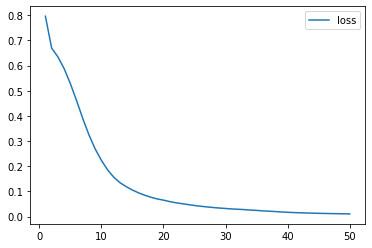

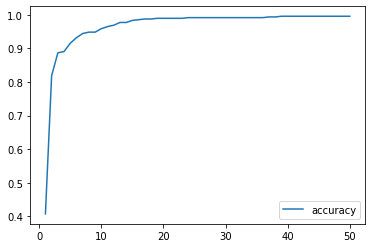

In [9]:
G1 = ["G1", "G2", "G3"]
G2 = ["G2", "G3"]
G3 = ["G3"]

dnn(por, "G3", G3)

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 112)               6384      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 565       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 6,955
Trainable params: 6,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 0s 1ms/step - loss: 0.6880 - accuracy: 0.5811
Epoch 2/50
10/10 [==============================] - 0s 800us/step - loss: 0.6080 - accuracy: 0.6385
Epoch 3/50
10/10 [==============================] - 0s 1000us/step - loss: 0.5633 - accuracy: 0.6824
Epoch 4/50
10/10 [==============================] - 0s 1000us/step - loss: 0.5316 - a

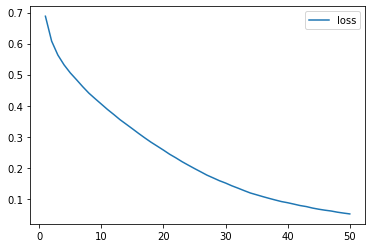

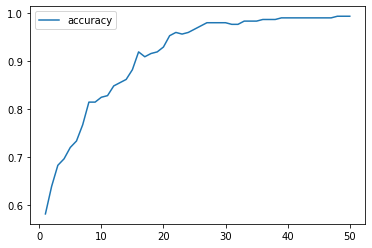

In [4]:
# math G1

# Generate our categorical variable list
encode_cat = math.dtypes[math.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
math[encode_cat].nunique()

# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(math[encode_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(encode_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
math = math.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
display(math.head())

# Split our preprocessed data into our features and target arrays
y = math["G1"].values
X = math.drop(["G1", "G2", "G3"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * 2
hidden_nodes_layer2 = len(X_train[0]) * .1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))

""
0
1
2
3
4


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 114)               6612      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 575       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 6         
Total params: 7,193
Trainable params: 7,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 0s 1000us/step - loss: 0.7440 - accuracy: 0.4797
Epoch 2/50
10/10 [==============================] - 0s 1ms/step - loss: 0.6597 - accuracy: 0.6318
Epoch 3/50
10/10 [==============================] - 0s 798us/step - loss: 0.6104 - accuracy: 0.7196
Epoch 4/50
10/10 [==============================] - 0s 900us/step - loss: 0.5633 - 

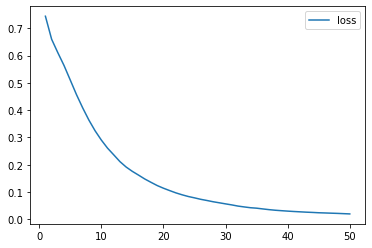

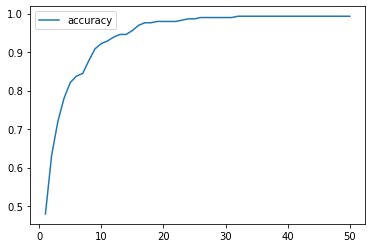

In [5]:
# math G2

# Generate our categorical variable list
encode_cat = math.dtypes[math.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
math[encode_cat].nunique()

# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(math[encode_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(encode_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
math = math.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
display(math.head())

# Split our preprocessed data into our features and target arrays
y = math["G2"].values
X = math.drop(["G2", "G3"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * 2
hidden_nodes_layer2 = len(X_train[0]) * .1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))

""
0
1
2
3
4


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 116)               6844      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 585       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 6         
Total params: 7,435
Trainable params: 7,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
10/10 [==============================] - 0s 1ms/step - loss: 0.6680 - accuracy: 0.5946
Epoch 2/50
10/10 [==============================] - 0s 1ms/step - loss: 0.5349 - accuracy: 0.7331
Epoch 3/50
10/10 [==============================] - 0s 1ms/step - loss: 0.4635 - accuracy: 0.7770
Epoch 4/50
10/10 [==============================] - 0s 800us/step - loss: 0.4041 - accur

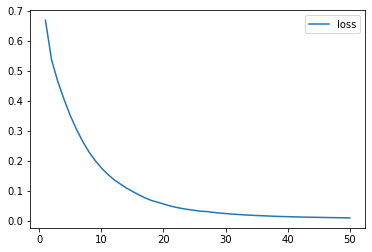

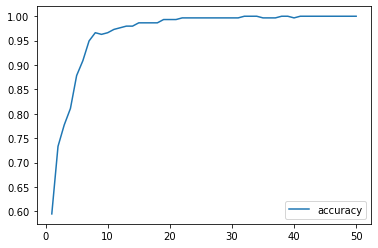

In [6]:
# math G3

# Generate our categorical variable list
encode_cat = math.dtypes[math.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
math[encode_cat].nunique()

# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(math[encode_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(encode_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
math = math.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
display(math.head())

# Split our preprocessed data into our features and target arrays
y = math["G3"].values
X = math.drop(["G3"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * 2
hidden_nodes_layer2 = len(X_train[0]) * .1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))

,school_GP,school_MS,sex_F,sex_M,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,Pstatus_T,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 112)               6384      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 565       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 6,955
Trainable params: 6,955
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 0s 1000us/step - loss: 0.6282 - accuracy: 0.6996
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.4767 - accuracy: 0.8025
Epoch 3/50
16/16 [==============================] - 0s 750us/step - loss: 0.4135 - accuracy: 0.8189
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.3732 - ac

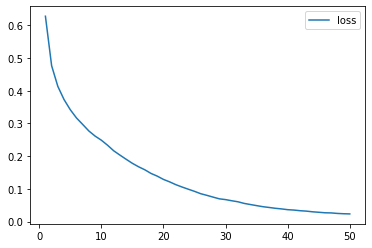

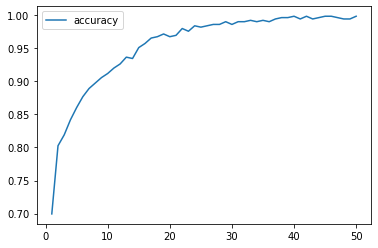

In [7]:
# por G1

# Generate our categorical variable list
encode_cat = por.dtypes[por.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
por[encode_cat].nunique()

# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(por[encode_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(encode_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
por = por.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
display(math.head())

# Split our preprocessed data into our features and target arrays
y = por["G1"].values
X = por.drop(["G1", "G2", "G3"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * 2
hidden_nodes_layer2 = len(X_train[0]) * .1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))

""
0
1
2
3
4


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 114)               6612      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 575       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 6         
Total params: 7,193
Trainable params: 7,193
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 0s 875us/step - loss: 0.6398 - accuracy: 0.6728
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.4617 - accuracy: 0.7819
Epoch 3/50
16/16 [==============================] - 0s 687us/step - loss: 0.3907 - accuracy: 0.7984
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.3495 - acc

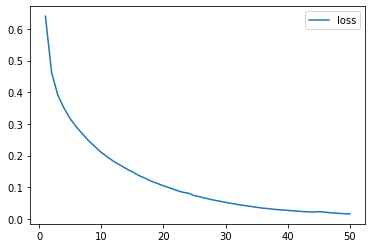

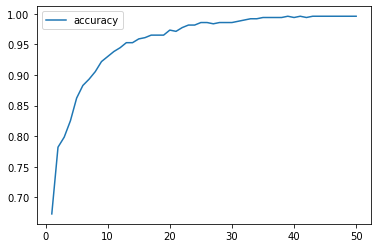

In [8]:
# por G2

# Generate our categorical variable list
encode_cat = por.dtypes[por.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
por[encode_cat].nunique()

# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(por[encode_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(encode_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
por = por.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
display(math.head())

# Split our preprocessed data into our features and target arrays
y = por["G2"].values
X = por.drop(["G2", "G3"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * 2
hidden_nodes_layer2 = len(X_train[0]) * .1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))

""
0
1
2
3
4


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,18,4,4,2,2,0,4,3,4,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,17,1,1,1,2,0,5,3,3,1,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,15,1,1,1,2,3,4,3,2,2,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,15,4,2,1,3,0,3,2,2,1,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,16,3,3,1,2,0,4,3,2,1,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 116)               6844      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 585       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 6         
Total params: 7,435
Trainable params: 7,435
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
16/16 [==============================] - 0s 812us/step - loss: 0.7228 - accuracy: 0.4259
Epoch 2/50
16/16 [==============================] - 0s 1ms/step - loss: 0.6659 - accuracy: 0.8210
Epoch 3/50
16/16 [==============================] - 0s 812us/step - loss: 0.5891 - accuracy: 0.8539
Epoch 4/50
16/16 [==============================] - 0s 1ms/step - loss: 0.4512 - acc

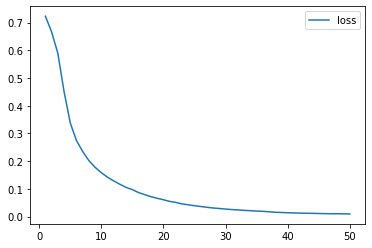

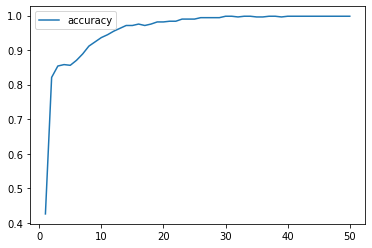

In [9]:
# por G3

# Generate our categorical variable list
encode_cat = por.dtypes[por.dtypes == "object"].index.tolist()

# Check the number of unique values in each column
por[encode_cat].nunique()

# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit the encoder and produce encoded DataFrame
encode_df = pd.DataFrame(enc.fit_transform(por[encode_cat]))

# Rename encoded columns
encode_df.columns = enc.get_feature_names(encode_cat)
display(encode_df.head())

# Merge the two DataFrames together and drop the Country column
por = por.merge(encode_df,left_index=True,right_index=True).drop(encode_cat, 1)
display(math.head())

# Split our preprocessed data into our features and target arrays
y = por["G3"].values
X = por.drop(["G3"],1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Define the model - deep neural net
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  len(X_train[0]) * 2
hidden_nodes_layer2 = len(X_train[0]) * .1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history, index=range(1,len(fit_model.history["loss"])+1))

# Plot the loss
display(history_df.plot(y="loss"))

# Plot the accuracy
display(history_df.plot(y="accuracy"))

# Conclusion
###### This actually surprised me how high the accuracy is on these models. I thought there would not be nearly enough rows for it to learn from. 
###### On the other hand it is less surprising that the models for the second and third trimesters are so good, because whether or not they passed the previous trimester is a really good predictor. 